In [1]:
import numpy as np
from matplotlib import patches
from matplotlib import pyplot as plt
%matplotlib inline


class MultiBox:
    def __init__(self, X, scales, ratios, rpn_stride):
        self.X = X
        self.scales = scales
        self.ratios = ratios
        self.rpn_stride = rpn_stride

    @property
    def shift(self):
        '''
        获取原图 (i,j) 位置的 reference box 的中心坐标
        '''
        h, w = self.X.shape[:2]
        ctr_init = (self.rpn_stride-1) / 2
        shiftX = np.arange(ctr_init, w, self.rpn_stride)
        shiftY = np.arange(ctr_init, h, self.rpn_stride)
        return shiftX, shiftY

    @property
    def aspects(self):
        '''
        依据给定的 scales, ratios 获取所有高宽组合
        '''
        scales = np.array(self.scales)
        ratios = np.array(self.ratios)[:, None]
        scaleX = scales / np.sqrt(ratios)
        scaleY = scaleX * ratios
        scaleX, scaleY = scaleX.flatten(), scaleY.flatten()
        return scaleY, scaleX

    @property
    def anchors(self):
        shiftX, shiftY = np.meshgrid(*self.shift)
        scaleY, scaleX = self.aspects
        centerX, anchorX = np.meshgrid(shiftX, scaleX)
        centerY, anchorY = np.meshgrid(shiftY, scaleY)
        anchor_center = np.stack([centerY, centerX], axis=2).reshape(-1, 2)
        anchor_size = np.stack([anchorY, anchorX], axis=2).reshape(-1, 2)-1
        boxes = np.concatenate(
            [anchor_center - .5 * anchor_size, anchor_center + .5 * anchor_size], axis=1)
        return boxes

    def viz(self, figsize=(10, 10)):
        '''
        可视化
        '''
        plt.figure(figsize=figsize)
        plt.imshow(self.X)

        Axs = plt.gca()
        for box in self.anchors:
            rec = patches.Rectangle(
                (box[0], box[1]), box[2]-box[0], box[3] - box[1], edgecolor='g', facecolor='None')
            Axs.add_patch(rec)


class MultiBoxPrior(MultiBox):
    def __init__(self, X, scales, ratios, rpn_stride):
        super().__init__(X, scales, ratios, rpn_stride)

    @property
    def aspects(self):
        '''
        依据给定的 scales, ratios 获取所有高宽组合
        '''
        scales = np.array(self.scales)
        ratios = np.array(self.ratios)
        scaleX = np.concatenate(
            [scales[0] / np.sqrt(ratios), scales[1:] / np.sqrt(ratios[0])])
        scaleY = np.concatenate(
            [scales[0] * np.sqrt(ratios), scales[1:] * np.sqrt(ratios[0])])
        return scaleY, scaleX

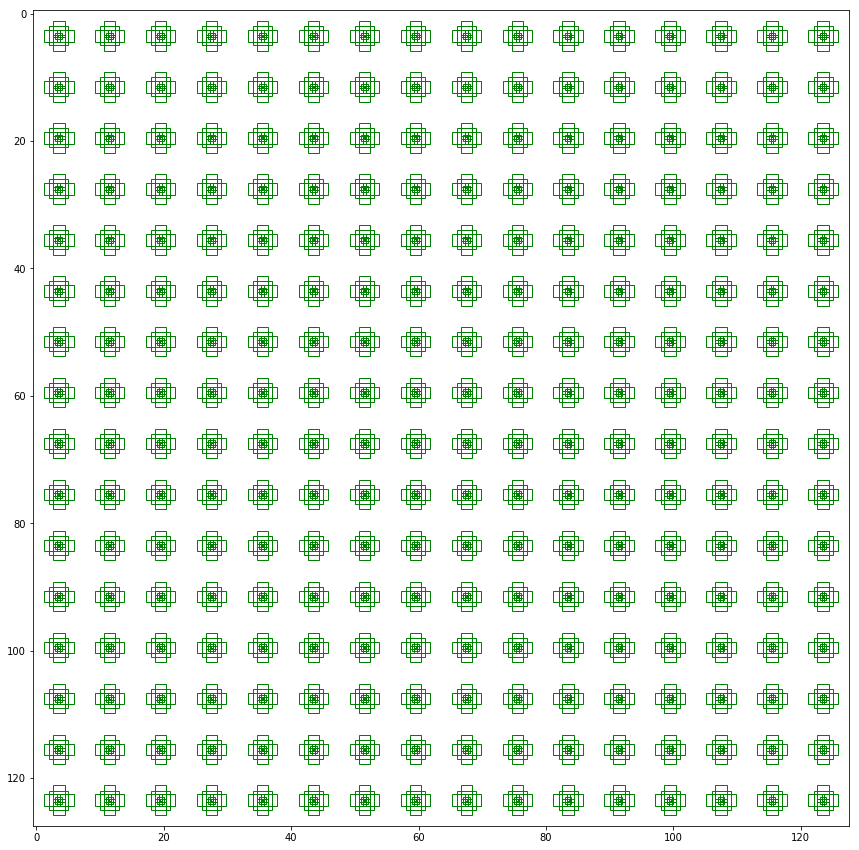

In [2]:
#  缩放比例
rpn_stride = 8  # 16 * 8 原图
scales = [1, 2, 4]  # 尺度，面积比
ratios = [0.5, 1, 2]  # window（滑动窗口） 与锚框的面积的比率（aspect ratios）
X = np.ones((128, 128, 3))

self = MultiBox(X, scales, ratios, rpn_stride)
self.viz((15,15))

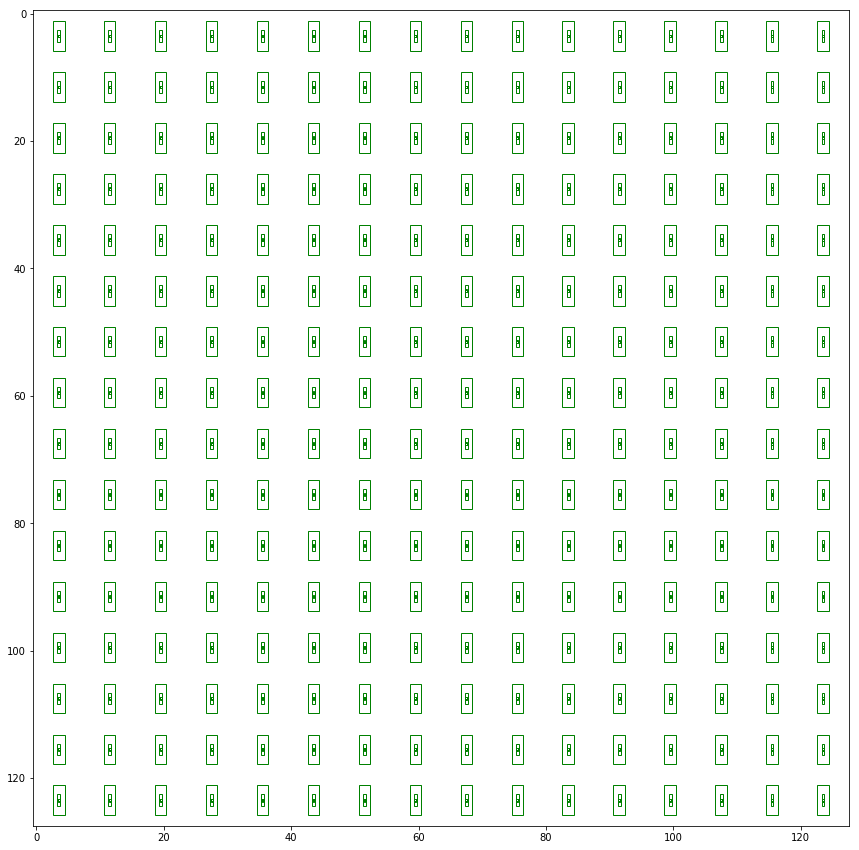

In [3]:
self = MultiBoxPrior(X, scales, ratios, rpn_stride)
self.viz((15,15))

In [4]:
self.anchors

array([[  3.64644661,   3.29289322,   3.35355339,   3.70710678],
       [  3.64644661,  11.29289322,   3.35355339,  11.70710678],
       [  3.64644661,  19.29289322,   3.35355339,  19.70710678],
       ...,
       [122.58578644, 105.17157288, 124.41421356, 109.82842712],
       [122.58578644, 113.17157288, 124.41421356, 117.82842712],
       [122.58578644, 121.17157288, 124.41421356, 125.82842712]])